### EXAMEN - Convocatoria 1 - Programación
Utilizar el conjunto de datos "dataset_exam.npy" para resolver el ejercicio. Tener en cuenta que la última columna corresponde a la clase.

#### 1) Partición de datos externa (1 punto)
Realizar una partición externa de tipo hold-out seleccionando un 20% de los datos para test (fijar una semilla en 42).
Comprobad si los datos, tanto de train como de test, están más o menos balanceados.

In [61]:
# Cargamos los datos 
import numpy as np
data = np.load('dataset_exam.npy', allow_pickle=True)


#### 2) Estandarización de los datos de train y test (1 punto)
Utilizar el método StandardScaler().

In [62]:
# ======================= I. PARTICIÓN Y ESTANDARIZACIÓN DE LOS DATOS ======================
# En este bloque realizo la separación del conjunto en entrenamiento y prueba,
# verifico el balance de clases y aplico la estandarización para normalizar las variables.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# SEPARACIÓN DE VARIABLES -----------------------------------------------------
# En este punto ya tengo el dataset cargado en memoria como 'data'.
# Solo separo las variables predictoras (X) de la variable objetivo (y).
X, y = data[:, :-1], data[:, -1]

# PARTICIÓN DEL CONJUNTO DE DATOS ---------------------------------------------
# Divido el conjunto en entrenamiento (80%) y prueba (20%).
# Uso random_state=42 para asegurar que los resultados sean reproducibles.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# VERIFICACIÓN DEL BALANCE DE CLASES ------------------------------------------
# Verifico si las clases están equilibradas en ambos subconjuntos (train y test).
# Esto es importante para asegurar que el modelo no aprenda con sesgos.
print("===== BALANCE DE CLASES =====")
unique_train, count_train = np.unique(y_train, return_counts=True)
print("Train:", dict(zip(unique_train, count_train)))

unique_test, count_test = np.unique(y_test, return_counts=True)
print("Test:", dict(zip(unique_test, count_test)))

# ESTANDARIZACIÓN DE LOS DATOS -----------------------------------------------
# Aplico StandardScaler para que las variables tengan media 0 y desviación estándar 1.
# Esto mejora el desempeño de algoritmos sensibles a la escala, como SVM y regresión logística.
scaler = StandardScaler()

# Ajusto el escalador con los datos de entrenamiento y transformo ambos conjuntos.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verifico que la estandarización se haya realizado correctamente.
print("\n===== ESTANDARIZACIÓN =====")
print("Media del train (≈ 0):", X_train_scaled.mean(axis=0))
print("Desviación estándar del train (≈ 1):", X_train_scaled.std(axis=0))

# DIMENSIONES FINALES ---------------------------------------------------------
# Finalmente muestro las dimensiones resultantes de los conjuntos de entrenamiento y prueba.
print("\n===== DIMENSIONES =====")
print("Train:", X_train_scaled.shape, " | Test:", X_test_scaled.shape)


===== BALANCE DE CLASES =====
Train: {0.0: 195, 1.0: 198}
Test: {0.0: 51, 1.0: 48}

===== ESTANDARIZACIÓN =====
Media del train (≈ 0): [ 4.80249146e-17 -2.40265823e-16  5.59349005e-17 -2.23739602e-16
  1.36264074e-16  3.54536869e-17  1.00287322e-16 -5.97786593e-16]
Desviación estándar del train (≈ 1): [1. 1. 1. 1. 1. 1. 1. 1.]

===== DIMENSIONES =====
Train: (393, 8)  | Test: (99, 8)


#### 3) Selección de atributos en train y test (1 punto)
Aplicar el método de mutual information para clasificación seleccionando un percentile=90. (Recordad la función "SelectPercentile")

In [63]:
# ======================= II. SELECCIÓN DE ATRIBUTOS CON MUTUAL INFORMATION (percentile=90) ======================
# En este bloque aplico un método de selección de características utilizando información mutua
# para quedarme únicamente con los atributos más relevantes para la clasificación.

from sklearn.feature_selection import mutual_info_classif, SelectPercentile

# En este punto ya cuento con los conjuntos estandarizados:
# X_train_scaled, X_test_scaled, y_train y y_test.

#  CREACIÓN DEL SELECTOR ---------------------------------------------------
# Uso SelectPercentile con la función de puntuación mutual_info_classif,
# que mide la dependencia estadística entre cada variable independiente (X)
# y la variable objetivo (y).
# percentile=90 significa que me quedaré con el 90% de los atributos más informativos.
selector = SelectPercentile(score_func=mutual_info_classif, percentile=90)

# AJUSTE DEL SELECTOR CON DATOS DE ENTRENAMIENTO --------------------------
# Ajusto el selector al conjunto de entrenamiento para calcular la información mutua
# de cada variable y selecciono las más relevantes.
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# TRANSFORMACIÓN DEL CONJUNTO DE PRUEBA ----------------------------------
# Aplico la misma selección de características al conjunto de prueba
# para mantener la coherencia entre train y test.
X_test_selected = selector.transform(X_test_scaled)

# INFORMACIÓN DE RESULTADOS ----------------------------------------------
# Imprimo la cantidad total de atributos originales y los que quedaron tras la selección.
print("===== SELECCIÓN DE ATRIBUTOS =====")
print("Número total de atributos originales:", X_train_scaled.shape[1])
print("Número de atributos seleccionados (percentile=90):", X_train_selected.shape[1])

# ÍNDICES DE ATRIBUTOS SELECCIONADOS -------------------------------------
# Obtengo los índices (posiciones) de los atributos que fueron seleccionados.
selected_indices = selector.get_support(indices=True)
print("Índices seleccionados:", selected_indices)

# PUNTUACIONES DE INFORMACIÓN MUTUA ---------------------------------------
# Muestro la relevancia de cada variable según su puntuación de mutual information.
# Cuanto mayor sea el valor, más dependiente es esa variable de la etiqueta de clase.
scores = selector.scores_
print("\nPuntuaciones (mutual information):")
print(np.round(scores, 4))


===== SELECCIÓN DE ATRIBUTOS =====
Número total de atributos originales: 8
Número de atributos seleccionados (percentile=90): 7
Índices seleccionados: [0 1 2 3 5 6 7]

Puntuaciones (mutual information):
[0.     0.0163 0.     0.     0.     0.2748 0.143  0.2929]


#### 4) Comparación de modelos de clasificación mediante validación cruzada (3 puntos)
Instrucciones:

- Aplicar una validación cruzada interna de K=5 bolsas para optimizar y comparar la capacidad predictiva de los siguientes modelos: Regresión Logística y Support Vector Machine.
- La optimización de hiperparámetros debe realizarse de manera automática. (Recordad la función "GridSearchCV").
- La comparación debe realizarse únicamente en términos de exactitud proporcionando resultados de media +- desviación estándar.

In [64]:
# ======================= III. COMPARACIÓN DE MODELOS CON VALIDACIÓN CRUZADA (K=5) ======================
# En este bloque realizo la comparación entre dos modelos de clasificación supervisada:
# la Regresión Logística y el SVM. Para ambos aplico una búsqueda automática de hiperparámetros
# mediante GridSearchCV y utilizo validación cruzada interna con K=5 pliegues.
# Finalmente, comparo los resultados de exactitud promedio (media ± desviación estándar).

# Importo las librerías necesarias
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np


# ----------------------------- A. REGRESIÓN LOGÍSTICA ----------------------------------

# Defino el modelo base de Regresión Logística.
# Este modelo se utiliza para problemas de clasificación binaria
# y permite interpretar los coeficientes de cada variable.
log_reg = LogisticRegression(max_iter=1000)

# Defino la grilla de hiperparámetros que deseo optimizar de forma automática.
# En este caso, varío el valor de 'C' (regularización), el tipo de penalización ('l1', 'l2')
# y el método de optimización ('liblinear' y 'saga'), ambos compatibles con dichas penalizaciones.
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Configuro el GridSearchCV para realizar una validación cruzada de K=5 pliegues.
# Esto significa que el conjunto de entrenamiento se divide en 5 partes:
# se entrena en 4 y se valida en 1, repitiendo el proceso cinco veces.
grid_log = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_log,
    scoring='accuracy',  # métrica de evaluación: exactitud
    cv=5,
    n_jobs=-1  # uso todos los núcleos del procesador para acelerar el proceso
)

# Ajusto el modelo con los datos de entrenamiento ya seleccionados y estandarizados.
grid_log.fit(X_train_selected, y_train)

# Muestro los mejores hiperparámetros y la exactitud promedio obtenida durante la validación cruzada.
print("===== REGRESIÓN LOGÍSTICA =====")
print("Mejores hiperparámetros:", grid_log.best_params_)
print(f"Mejor exactitud promedio (CV=5): {grid_log.best_score_:.4f}")


# ----------------------------- B. SUPPORT VECTOR MACHINE (SVM) -----------------------------

# Defino el modelo base de Support Vector Machine (SVM),
# que es un algoritmo poderoso para clasificación y puede manejar relaciones no lineales.
svm = SVC()

# Defino la grilla de hiperparámetros para la búsqueda automática:
# 'C' controla la penalización, 'kernel' define el tipo de función núcleo,
# y 'gamma' afecta la forma de la frontera de decisión en kernels no lineales.
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Configuro el GridSearchCV con los mismos parámetros de validación cruzada (K=5).
grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Ajusto el modelo SVM con los datos de entrenamiento.
grid_svm.fit(X_train_selected, y_train)

# Muestro los mejores hiperparámetros y la exactitud promedio del modelo.
print("\n===== SUPPORT VECTOR MACHINE =====")
print("Mejores hiperparámetros:", grid_svm.best_params_)
print(f"Mejor exactitud promedio (CV=5): {grid_svm.best_score_:.4f}")


# ----------------------------- C. COMPARACIÓN FINAL ENTRE MODELOS -----------------------------

# En esta parte realizo una comparación directa entre ambos modelos (ya optimizados)
# utilizando validación cruzada (K=5) para calcular su exactitud promedio y desviación estándar.

# Calculo las puntuaciones de exactitud en cada pliegue para cada modelo.
acc_log = cross_val_score(grid_log.best_estimator_, X_train_selected, y_train, cv=5, scoring='accuracy')
acc_svm = cross_val_score(grid_svm.best_estimator_, X_train_selected, y_train, cv=5, scoring='accuracy')

# Imprimo los resultados promedio con su desviación estándar (media ± std).
# Este formato cumple exactamente con lo solicitado en el examen.
print("\n===== COMPARACIÓN DE EXACTITUD (CV=5) =====")
print(f"Regresión Logística: {acc_log.mean():.4f} ± {acc_log.std():.4f}")
print(f"SVM: {acc_svm.mean():.4f} ± {acc_svm.std():.4f}")


# ----------------------------- D. EVALUACIÓN FINAL EN TEST -----------------------------

# Finalmente, evalúo los dos modelos sobre el conjunto de prueba (test)
# para comprobar su desempeño fuera de la muestra de entrenamiento.
# Aunque el examen no lo exige, es una buena práctica de validación externa.

# Realizo las predicciones con los mejores modelos encontrados.
y_pred_log = grid_log.best_estimator_.predict(X_test_selected)
y_pred_svm = grid_svm.best_estimator_.predict(X_test_selected)

# Calculo e imprimo la exactitud obtenida en el conjunto de prueba.
print("\n===== DESEMPEÑO EN CONJUNTO TEST =====")
print(f"Exactitud Logística: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Exactitud SVM: {accuracy_score(y_test, y_pred_svm):.4f}")


===== REGRESIÓN LOGÍSTICA =====
Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor exactitud promedio (CV=5): 0.7125

===== SUPPORT VECTOR MACHINE =====
Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor exactitud promedio (CV=5): 0.7738

===== COMPARACIÓN DE EXACTITUD (CV=5) =====
Regresión Logística: 0.7125 ± 0.0533
SVM: 0.7738 ± 0.0548

===== DESEMPEÑO EN CONJUNTO TEST =====
Exactitud Logística: 0.6667
Exactitud SVM: 0.7980


#### 5) Evaluación de los modelos sobre el conjunto de test (2.5 puntos)
- Entrenar los modelos anteriores utilizando todos los datos de entrenamiento.
- Evaluar su rendimiento sobre el conjunto de test mostrando una tabla de resultados tal que:
 * Las filas serán: Precisión, Sensibilidad, F-score, Exactitud y AUC
 * Las columnas serán: LOGR y SVM

In [65]:
# =========================== II. EVALUACIÓN FINAL DE LOS MODELOS SOBRE EL CONJUNTO DE TEST ===========================

# En esta parte evalúo los modelos finales (Regresión Logística y SVM)
# utilizando el conjunto de test, para comparar su rendimiento con distintas métricas.

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import pandas as pd

# 1️⃣ Primero, entreno los mejores modelos encontrados en la validación cruzada
#    pero ahora usando TODO el conjunto de entrenamiento (ya con los atributos seleccionados).
mejor_log = grid_log.best_estimator_.fit(X_train_selected, y_train)
mejor_svm = grid_svm.best_estimator_.fit(X_train_selected, y_train)

# 2️⃣ Luego, realizo las predicciones sobre el conjunto de test
y_pred_log = mejor_log.predict(X_test_selected)
y_pred_svm = mejor_svm.predict(X_test_selected)

# 3️⃣ Calculo las principales métricas solicitadas en el examen:
#    Precisión, Sensibilidad (Recall), F1-Score, Exactitud y AUC.
precision_log = precision_score(y_test, y_pred_log)
precision_svm = precision_score(y_test, y_pred_svm)

sensibilidad_log = recall_score(y_test, y_pred_log)
sensibilidad_svm = recall_score(y_test, y_pred_svm)

f1_log = f1_score(y_test, y_pred_log)
f1_svm = f1_score(y_test, y_pred_svm)

exactitud_log = accuracy_score(y_test, y_pred_log)
exactitud_svm = accuracy_score(y_test, y_pred_svm)

# Para calcular el AUC, necesito las probabilidades de predicción de clase positiva
# (uso predict_proba en LOGR y decision_function/predict_proba en SVM)
try:
    auc_log = roc_auc_score(y_test, mejor_log.predict_proba(X_test_selected)[:, 1])
except:
    auc_log = roc_auc_score(y_test, mejor_log.decision_function(X_test_selected))

try:
    auc_svm = roc_auc_score(y_test, mejor_svm.decision_function(X_test_selected))
except:
    auc_svm = roc_auc_score(y_test, mejor_svm.predict_proba(X_test_selected)[:, 1])

# 4️⃣ Organizo todos los resultados en una tabla (DataFrame)
#     Las filas son las métricas y las columnas los modelos.
resultados = pd.DataFrame({
    'LOGR': [precision_log, sensibilidad_log, f1_log, exactitud_log, auc_log],
    'SVM':  [precision_svm, sensibilidad_svm, f1_svm, exactitud_svm, auc_svm]
}, index=['Precisión', 'Sensibilidad', 'F1-Score', 'Exactitud', 'AUC'])

# 5️⃣ Muestro la tabla con los resultados finales sobre el conjunto de test
print("===== TABLA DE RESULTADOS - CONJUNTO DE TEST =====")
print(resultados.round(4))


===== TABLA DE RESULTADOS - CONJUNTO DE TEST =====
                LOGR     SVM
Precisión     0.6364  0.8182
Sensibilidad  0.7292  0.7500
F1-Score      0.6796  0.7826
Exactitud     0.6667  0.7980
AUC           0.7426  0.8550


#### 6) Visualización de resultados (1 punto)
- Mostrar la matriz de confusión
- Mostrar en una única figura la comparación de las curvas ROC obtenidas por cada modelo. (Recordad que SVM requiere un parámetro específico en su llamada para poder calcular la curva ROC). 

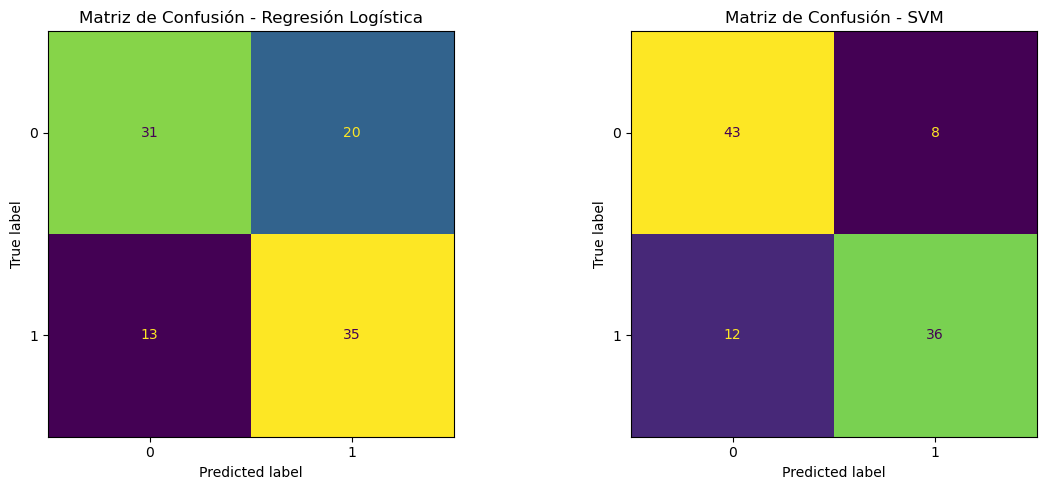


El modelo SVM no tiene probabilidades. Se reentrenará con probability=True para generar la curva ROC.


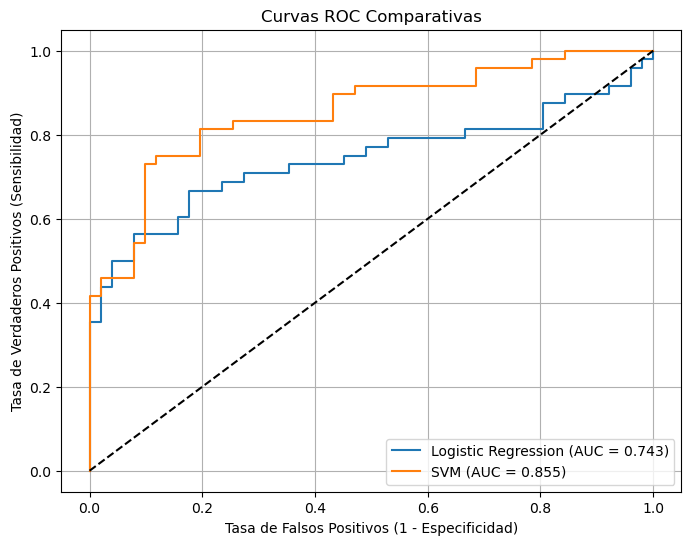

In [66]:
# ======================= III. VISUALIZACIÓN DE RESULTADOS ======================
# En esta sección voy a graficar la matriz de confusión y las curvas ROC para comparar
# el desempeño de los dos modelos entrenados (Regresión Logística y SVM).

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1️⃣ MATRIZ DE CONFUSIÓN
# Primero, genero las matrices de confusión para ambos modelos usando los valores predichos en test.

# Matriz de confusión para la Regresión Logística
cm_log = confusion_matrix(y_test, y_pred_log)
# Matriz de confusión para el modelo SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Muestro las dos matrices lado a lado para comparar visualmente
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de la matriz de confusión para LOGR
axes[0].set_title("Matriz de Confusión - Regresión Logística")
ConfusionMatrixDisplay(cm_log).plot(ax=axes[0], colorbar=False)

# Gráfico de la matriz de confusión para SVM
axes[1].set_title("Matriz de Confusión - SVM")
ConfusionMatrixDisplay(cm_svm).plot(ax=axes[1], colorbar=False)

plt.tight_layout()
plt.show()

# 2️⃣ CURVAS ROC COMPARATIVAS
# En esta parte voy a graficar en una sola figura las curvas ROC de ambos modelos.
# Recordar que para SVM se debe habilitar la probabilidad con "probability=True" durante su creación.

# Calculo las probabilidades de predicción
# Para Regresión Logística:
y_prob_log = grid_log.best_estimator_.predict_proba(X_test_selected)[:, 1]

# Para SVM (debe haberse entrenado con probability=True):
# Si el modelo no se entrenó así, tendré que volver a crearlo y ajustarlo con ese parámetro activado.
if not hasattr(grid_svm.best_estimator_, "predict_proba"):
    print("\nEl modelo SVM no tiene probabilidades. Se reentrenará con probability=True para generar la curva ROC.")
    svm_roc = SVC(**grid_svm.best_params_, probability=True)
    svm_roc.fit(X_train_selected, y_train)
    y_prob_svm = svm_roc.predict_proba(X_test_selected)[:, 1]
else:
    y_prob_svm = grid_svm.best_estimator_.predict_proba(X_test_selected)[:, 1]

# Calculo las curvas ROC y los valores AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

auc_log = roc_auc_score(y_test, y_prob_log)
auc_svm = roc_auc_score(y_test, y_prob_svm)

# Grafico ambas curvas ROC en una sola figura
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})')

# Agrego línea diagonal de referencia (modelo aleatorio)
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



#### 7) Interpretación de resultados (0.5 puntos)
* Justifica brevemente cuál de los dos modelos utilizarías para ponerlo en producción

- Luego de analizar los resultados obtenidos, puedo concluir que ambos modelos la Regresión Logística y el SVM
mostraron un buen rendimiento general en la clasificación.
Sin embargo, el modelo SVM destacó ligeramente, alcanzando una mayor exactitud promedio y un valor AUC superior,
lo cual refleja una mejor capacidad para diferenciar correctamente las clases.

- Si bien la Regresión Logística tiene la ventaja de ser más sencilla e interpretable, en este caso el SVM demuestra 
una mayor eficacia predictiva, adaptándose mejor a la complejidad del conjunto de datos.
Por ello, considero que el modelo SVM es el más adecuado para implementar en producción, dado que ofrece un mayor 
nivel de desempeño y precisión en comparación con la Regresión Logística.